In [1]:
%load_ext autoreload
%autoreload 2

%matplotlib inline

In [2]:
#export
from exp.nb_04 import *

## Initial setup

[Jump_to lesson 9 video](https://course.fast.ai/videos/?lesson=9&t=7013)

In this notebooks we will use what we learned in notebook 04 to do *one-cycle training*. In the coming lessons we will do a deep dive on the dynamics of how models train by using *hooks*. In a nutshell, if you manage to get the first batches working well, everything becomes easier, in the sense that you can get *superconvergence*, and for this good *annealing* is critical. We start as before getting our data, creating a `DataBunch`, a `Learner` and a `Runner`.

In [3]:
x_train, y_train, x_valid, y_valid = get_data()
train_ds, valid_ds = Dataset(x_train, y_train), Dataset(x_valid, y_valid)
nh, bs = 50, 512
c = y_train.max().item() + 1
loss_func = F.cross_entropy

In [4]:
data = DataBunch(*get_dls(train_ds, valid_ds, bs), c)

In [5]:
#export
def create_learner(model_func, loss_func, data):
    return Learner(*model_func(data), loss_func, data)

This model has a learning rate of 0.5.

In [6]:
learn = create_learner(get_model, loss_func, data)
run = Runner([AvgStatsCallback([accuracy])])

run.fit(3, learn)

train: [0.65844296875, tensor(0.8064)]
valid: [0.3609395751953125, tensor(0.8818)]
train: [0.302329921875, tensor(0.9114)]
valid: [0.23725029296875, tensor(0.9326)]
train: [0.23764013671875, tensor(0.9316)]
valid: [0.2054995849609375, tensor(0.9413)]


We can change it to 0.3, and see how it changes.

In [7]:
learn = create_learner(partial(get_model, lr=0.3), loss_func, data)
run = Runner([AvgStatsCallback([accuracy])])

run.fit(3, learn)

train: [0.75510015625, tensor(0.8060)]
valid: [0.369033740234375, tensor(0.8967)]
train: [0.352794375, tensor(0.8983)]
valid: [0.296351318359375, tensor(0.9153)]
train: [0.3041775, tensor(0.9124)]
valid: [0.2633372314453125, tensor(0.9249)]


Let's create a function that returns a model with a given learning rate.

In [8]:
#export
def get_model_func(lr=0.5):
    return partial(get_model, lr=lr)

## Annealing

We define two new callbacks: the Recorder to save track of the loss and our scheduled learning rate, and a ParamScheduler that can schedule any hyperparameter as long as it's registered in the state_dict of the optimizer. 

[Jump_to lesson 9 video](https://course.fast.ai/videos/?lesson=9&t=7202)

We are going to create a callback that does hyperparameter scheduling. In this notebook we will only look into the learning rate, but in the last 12 months one interesting area of research has been on scheduling other things, like the dropout rate, weight decay, momentum, what type of data augmentation you use, etc. This makes sense as one observation is that the loss landscape of NNs looks very different at the beginning, in the middle, and at the end of the training process. It is therefore very unlikely that you want to have the same hyperparameters throughout training.

The `Recorder` class allows us to look into the learning rates and the losses at each batch. As there might be multiple learning rate, one for each parameter group, in fastai the `Recorder` only stores the learning rate of the final layer. There are also plotting functions for visualization.

In [9]:
#export
class Recorder(Callback):
    def begin_fit(self):
        self.lrs = []
        self.losses = []

    def after_batch(self):
        if not self.in_train:
            return
        self.lrs.append(self.opt.param_groups[-1]['lr'])
        self.losses.append(self.loss.detach().cpu())

    def plot_lr(self):
        plt.plot(self.lrs)

    def plot_loss(self):
        plt.plot(self.losses)

We are going to pass the name of a parameter `param` (in our case `lr` to `__init__()` and a scheduling function `sched_func`. The `sched_func` will take the fraction of the total number of epochs we are in, and for each parameter group, it will set the parameter of interest to that particular value. We don't necessarily want to have the same value of a hyperparameter, in this case the learning rate, for all our layers. This is why we use the parameter groups (abstracted to *layer groups* in fastai, but pretty much the same thing). Parameter groups are contained in the *optimizer*. A PyTorch optimizer usually contains only one parameter group, unless specified otherwise.

Every time we start a new batch (`begin_batch()`) we call `set_param()`.

In [10]:
class ParamScheduler(Callback):
    _order = 1

    def __init__(
            self, pname, sched_func):
        self.pname = pname
        self.sched_func = sched_func

    def set_param(self):
        for pg in self.opt.param_groups:
            pg[self.pname] = self.sched_func(self.n_epochs / self.epochs)

    def begin_batch(self):
        if self.in_train:
            self.set_param()

As we said before, `sched_func` takes the fraction of the total number of epochs, so a number between 0 and 1.
Let's start with a simple linear schedule going from start to end. It returns a function that takes a `pos` argument (going from 0 to 1) such that this function goes from `start` (at `pos=0`) to `end` (at `pos=1`) in a linear fashion. Note that `pos` is a number between 0 and 1, but `start` and `end` are the initial and the final learning rates. The `_inner` function takes `start`, `end` and `pos` and returns a learning rate, which is the learning rate we should have at position `pos` by following a linear schedule. To convert `_inner` into a function that only takes `pos` we again use `partial`.

[Jump_to lesson 9 video](https://course.fast.ai/videos/?lesson=9&t=7431)

In [11]:
def sched_lin(start, end):
    def _inner(start, end, pos):
        return start + pos * (end - start)
    return partial(_inner, start, end)

The above solution works fine, but since we are going to use many schedulers, we don't want to rewrite this function every time. We can therefore it refactor with a **decorator**. We can define `sched_lin` in the natural way, taking `start`, `end`, `pos`. The `@annealer` decorator is the part that takes care of returning the partial function.

How does the decorator work? Since `sched_lin` has an `@annealer` decorator, it is passed as an argument to the decorator function `annealer`, and the definition of `sched_lin` is replaced with whatever `anneal` returns, in this case `_inner`.

[Jump_to lesson 9 video](https://course.fast.ai/videos/?lesson=9&t=7526)

In [12]:
#export
def annealer(f):
    def _inner(start, end):
        return partial(f, start, end)
    return _inner


@annealer
def sched_lin(start, end, pos):
    return start + pos*(end - start)

In [13]:
# shift-tab works too, in Jupyter!
# It works in Emacs too!!!
# sched_lin()

In the code below, `f = f(pos)`.

In [14]:
f = sched_lin(1,2)
f(0.3)

1.3

We can now define many other schedulers. For example, `sched_no` always returns the `start` value.

It is not possible to plot `torch.Tensors`, but the only reason is that they don't have an `ndim` attribute. The dirty trick in the last line below, adds it. You can read more about `property` [here](https://docs.python.org/3/library/functions.html#property) and more in general [here](https://docs.python.org/3/howto/descriptor.html).

In [15]:
#export
@annealer
def sched_cos(start, end, pos):
    return start + (1 + math.cos(math.pi*(1-pos))) * (end-start) / 2


@annealer
def sched_no(start, end, pos):
    return start


@annealer
def sched_exp(start, end, pos):
    return start * (end/start) ** pos


def cos_1cycle_anneal(start, high, end):
    return [sched_cos(start, high), sched_cos(high, end)]


# This monkey-patch is there to be able to plot tensors
torch.Tensor.ndim = property(lambda x: len(x.shape))

[Jump_to lesson 9 video](https://course.fast.ai/videos/?lesson=9&t=7730)

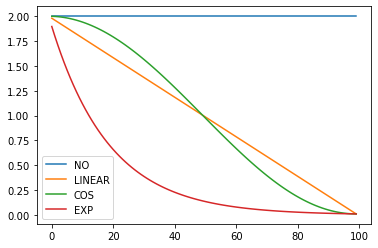

In [16]:
annealings = "NO LINEAR COS EXP".split()

a = torch.arange(0, 100)
p = torch.linspace(0.01,1,100)

fns = [sched_no, sched_lin, sched_cos, sched_exp]
for fn, t in zip(fns, annealings):
    f = fn(2, 1e-2)
    plt.plot(a, [f(o) for o in p], label=t)
plt.legend();

This is still not enough. If you want to do one-cycle scheduling you need some type of warmup and some type of cool-down or, if you do something like SGDI, you have multiple cool-downs. In practice, we'll often want to combine different schedulers, the following function does that: it uses `scheds[i]` for `pcts[i]` of the training.

In [17]:
#export
def combine_scheds(pcts, scheds):
    assert sum(pcts) == 1.
    pcts = tensor([0] + listify(pcts))
    assert torch.all(pcts >= 0)
    pcts = torch.cumsum(pcts, 0)

    def _inner(pos):
        idx = (pos >= pcts).nonzero().max()
        actual_pos = (pos-pcts[idx]) / (pcts[idx + 1] - pcts[idx])
        return scheds[idx](actual_pos)
    return _inner

Here is an example: use 30% of the budget to go from 0.3 to 0.6 following a cosine, then the last 70% of the budget to go from 0.6 to 0.2, still following a cosine.

In [18]:
sched = combine_scheds([0.3, 0.7], [sched_cos(0.3, 0.6), sched_cos(0.6, 0.2)]) 

The scheduler shown below is the one used by default by fastai. It's not published anywhere. There is a gentle warmup at the beginning, but it doesn't take long, and we will see this when talking about hooks, to get into a nice region of the loss landscape. One thing that people have started realizing only recently (although Leslie Smith said it already two years ago) is that you need to train at a high learning rate for a long time, and this is what this scheduler does. However, you also need to fine tune at a low learning rate for a long time, and this is what we do.

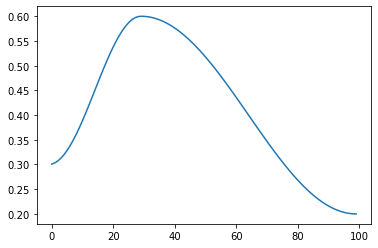

In [19]:
plt.plot(a, [sched(o) for o in p])

We can use it for training quite easily...

In [20]:
cbfs = [Recorder,
        partial(AvgStatsCallback,accuracy),
        partial(ParamScheduler, 'lr', sched)]

In [21]:
learn = create_learner(get_model_func(0.3), loss_func, data)
run = Runner(cb_funcs=cbfs)

In [22]:
run.fit(3, learn)

train: [0.78497828125, tensor(0.7881)]
valid: [0.367329638671875, tensor(0.8885)]
train: [0.2921208203125, tensor(0.9145)]
valid: [0.2324179443359375, tensor(0.9343)]
train: [0.234507734375, tensor(0.9332)]
valid: [0.2136328125, tensor(0.9412)]


... then check with our recorder if the learning rate followed the right schedule.

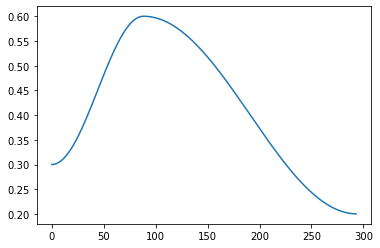

In [23]:
run.recorder.plot_lr()

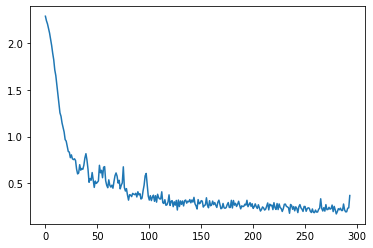

In [24]:
run.recorder.plot_loss()

We cannot add callbacks between layers, so next week we will first add them manually, and then we will take advantage of PyTorch hooks to plot and understand what happens inside our models while they are training, and we will find ways to train them more efficiently.

## Export

In [25]:
!./notebook2script.py 05_anneal.ipynb

Converted 05_anneal.ipynb to exp/nb_05.py
